# Predicting Loan Defaulters

-- Gyan Arora

---

In [1]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
plt.style.use('dark_background')

In [2]:
train_data = pd.read_csv('ML_Artivatic_dataset/train_indessa.csv')
test_data = pd.read_csv('ML_Artivatic_dataset/test_indessa.csv')
data = train_data.drop('loan_status', axis=1).append(test_data)
data.shape

(887379, 44)

---

## EDA

> Please refer to ```eda_report.html``` in this directory. Double click on the file and it should open in the browser. It has a full eda of the entire unprocessed dataset. I encourage you keep it open on th side since this notebook refers to it fairly often.

- Click of the feature to view its plots and stats.
- On the top there is a button ```Associations```. Click that to view all correlations. [IMPORTANT]

**Some important notes from the EDA**
- No single group strongly identifies the probability of loan defaults.
- Correlations are interesting:
    - loan_amnt, funded_amnt and funder_invester are correlated obviosuly. Further understanding in the next section.
    - grades, subgrades and interst_rates are correlated, which makes sense because safer loans are given out at lower interest rates than riskier loans.
    - annual_income is somewhat related to loan amount because richer people take bigger loans. This is again related to total curr balance.
    - total_interest_recieved again is obviosly related to the loan given, interest rate and other varaibles related to these two.
    - There are some correaltions with member id, maybe they arise from the way member ids are allocated by the bank (like zip codes can contain geographical info, member ids could be designed to encapsulate income group, length of loan, any other.). For the purpose of this exersice however, since it is not explicitly stated, I will ignore all correlations with this feature, and it altogether.
    - deliquency features are correlated along with last_major_derog.
    - recoveries and recovery fee are related
    - revolving credit limit and revolving balance  are related

---

## Feature Understanding and Engineering

### 1. member_id

- As noted in the EDA report, I acknowledge that ID's like zip-codes may encapsulate some useful information. And I do see some noticeable correlations of the id with other features, especially with loan_status (49%) which is the target variable. However, since I cannot confirm this (without talking to the owner of the data), I will assume that id is just an identifier and carries no information that can be confidently used to make future predictions in production. Hence this feature **will be dropped**

### 2. loan_amnt, funded_amnt, funded_amnt_inv

- From EDA report we know that these features are highly correlated. When plotted, the plot almost completely overlaps. So I see in how many cases are they not equal

In [38]:
print(np.isclose(data['loan_amnt'], data['funded_amnt'], rtol=0.05).sum()/len(data))
print(np.isclose(data['loan_amnt'], data['funded_amnt_inv'], rtol=0.05).sum()/len(data))
print(np.isclose(data['funded_amnt'], data['funded_amnt_inv'], rtol=0.05).sum()/len(data))

0.9977484254191276
0.9906623889003459
0.992240068786843


In [44]:
(train_data.loc[idx]['funded_amnt'] < train_data.loc[idx]['funded_amnt_inv']).sum()

0

- I see that the amount figures are usually within 5% of each other. In less than 1% of the cases they disagree. The question is, if they do, is that significant?
- Also I see that the investors either agree, or want to give out less loan than the bank decided to fund. i.e. the investors play it safe.
- I will now check, the cases of disagreement and see if that is a strong indicator of load defaults

In [50]:
idx = np.isclose(train_data['funded_amnt'], train_data['funded_amnt_inv'], rtol=0.05) == False
train_data.loc[idx]['loan_status'].value_counts(normalize=True)

1    0.770034
0    0.229966
Name: loan_status, dtype: float64

- Great! I find that if the investors wanted to give less loan than the funded amount, 77% of the time the customer actually did default.
- This is interesting because globally the distribution is 24% defaulters, but in this small group the distribution has inverted to 23% non-defaulter which can greatly help in predictions.
- I also experimented with different thresholds, at 1% we see a 50-50 split, at 10% it is 76-24. So 5% looks like the best threshold where we get a good number of rows that are applicable and still see strong prediction power.

**New Feature: investor_confidence**

In [52]:
investor_confidence = pd.Series(np.isclose(data['funded_amnt'], data['funded_amnt_inv'], rtol=0.05).astype(int))
investor_confidence.value_counts(normalize=True)

1    0.99224
0    0.00776
dtype: float64

- So 77% of these 0.7% of all samples can be expected to default. Well, its something.
- Also I will use only ```funded_amnt going forward``` and l```oan_amnt``` and ```funded_amnt_inv``` **will be dropped**

### 3. Term

- Simple binary catogorical variable, from EDA report we see that shorter loans (36 months) have a slighly higher default rate. (27% vs 15%)

### 4. Batch Enrolled

In [53]:
print('Unique Values:', data['batch_enrolled'].nunique())

Unique Values: 207


<AxesSubplot:title={'center':'Sizes of few batches'}>

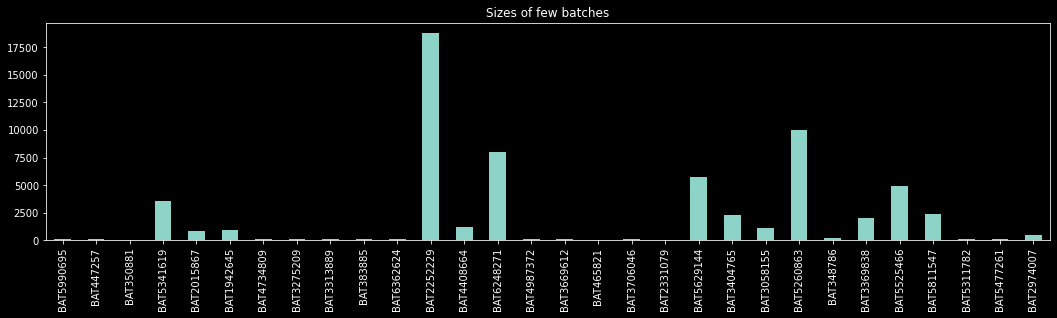

In [3]:
data['batch_enrolled'].value_counts().iloc[np.random.choice(207, 30, replace=False)].plot(kind='bar', figsize=(18, 4), title='Sizes of few batches')

- Batch sizes are not constant

In [58]:
tmp = train_data.groupby('batch_enrolled')['loan_status'].value_counts(normalize=True)
tmp.head(10)

batch_enrolled  loan_status
                0              0.763780
                1              0.236220
BAT1104812      0              0.914254
                1              0.085746
BAT1135695      1              0.784909
                0              0.215091
BAT1184694      0              0.927108
                1              0.072892
BAT1273836      1              0.880218
                0              0.119782
Name: loan_status, dtype: float64

- Some batches do seem to have a lower chance of loan defaults than others. This is however relevant if we expect to see the same batches in the future (test data) during real time deployment.

In [11]:
set(train_data['batch_enrolled'].unique()).intersection(set(test_data['batch_enrolled'].unique()))

{' ', nan}

- So we see that the test data has different batch ID's which actually makes sense. Hence using the batch number does not seem to be useful for making predictions. 
- We could further try to deduce if batch number contains any other embedded information, e.g. if the first 2 numbers indicate the grade of the loan, etc. To do this we would look for evidence in other variables that we have, but even if some relation is found, the information would be redundant. The quickest way is to contact the people who own the data (client) and clear any doubts/assumptions. 
- For this exercise I am assuming that the batch number is just generated sequentially and stays for a fixed period of time before the next batch becomes live. Hence **batch id will be dropped** as it shall not have any impact on predictions 

### 5. Interest Rate

- Simple numerical variable. Will do scaling during final pre-processing.

### 6. Grade and Sub-Grade

- EDA report indicates none of them are very strong predictors of loan_status. However this is a categorical feature. I would like to avoid so many categories. I will be converting grade to a numerical grade going from 1 to 35 with 1=A1 and 35=G5.
- Then I will be dropping both of these features and replacing with grade_map as follows

In [67]:
grade_map = {num: grade for num, grade in zip(range(1,36), sorted(data['sub_grade'].unique()))}
print(grade_map)

{1: 'A1', 2: 'A2', 3: 'A3', 4: 'A4', 5: 'A5', 6: 'B1', 7: 'B2', 8: 'B3', 9: 'B4', 10: 'B5', 11: 'C1', 12: 'C2', 13: 'C3', 14: 'C4', 15: 'C5', 16: 'D1', 17: 'D2', 18: 'D3', 19: 'D4', 20: 'D5', 21: 'E1', 22: 'E2', 23: 'E3', 24: 'E4', 25: 'E5', 26: 'F1', 27: 'F2', 28: 'F3', 29: 'F4', 30: 'F5', 31: 'G1', 32: 'G2', 33: 'G3', 34: 'G4', 35: 'G5'}


### 7. Employment Title

- There are too many employment titles. After studying their most common values I also see that there would be no efficient way to club them together.
- I could use external information from job-survey companies like LinkedIn, Naukri etc to get some meta information like income levels for each, contract/permanent, stability and growth etc for the common professions. If we had their employer info, like company name we cold also predict stability, future income levels etc.
- For this exercise, in the time that I have, since there is no quick way to reduce so many titles into compressed vectors and most models will get 'confused' so to speak with a sparse vector of this size I will be **dropping this variable**

### 8. Employment Length

- From EDA report:, 11 distinct values, 5% missing

In [73]:
data['emp_length'].value_counts(normalize=True)

10+ years    0.346054
2 years      0.093608
< 1 year     0.083799
3 years      0.083112
1 year       0.067764
5 years      0.066113
4 years      0.062345
7 years      0.052927
8 years      0.052169
6 years      0.050976
9 years      0.041133
Name: emp_length, dtype: float64

- From the report we see that employement length is somewhat correlated with ```funded_amnt``` and ```annual_inc.``` . We will train a linear regressor that will predict the years of experience based on ```funded_amnt``` and ```annual_inc```. Hopefully that will give us a good enough proxy

In [13]:
imp = IterativeImputer(max_iter=10, random_state=0)
emp_data = data[['emp_length', 'loan_amnt', 'annual_inc']].copy()
emp_data.loc[emp_data['emp_length'] == '< 1 year', 'emp_length'] = '0'
emp_data['emp_length'] = emp_data['emp_length'].apply(lambda x: int(re.sub("[^0-9]", '', x)) if isinstance(x, str) else np.nan)
filler = imp.fit_transform(emp_data)[:,0]
pd.Series(filler).isna().sum()  # 0 NaNs. 

### 9. Home OwnerShip

- Will be combining the categories ['OTHER', 'NONE', 'ANY'] = 'OTHER'

```python
data.loc[data['home_ownership'].isin(['OTHER', 'NONE', 'ANY']), 'home_ownership'] = 'OTHER'
```

### 10. Annual Income

- Simple numerical bariable with outliers.

```python
data.loc[data['annual_inc'] > data['annual_inc'].quantile(0.99), 'annual_inc'] = data['annual_inc'].quantile(0.99)
```

### 11. Verification Status

- Simple categorical, will be one-hot encoded.

### 12. Payment Plan

- The 2 categories are largely imbalanced. The smaller category 'y' has no evidence of strong prediction and is less than 1% (from EDA report). Hence this feature does not contain any information and **will be dropped**

In [86]:
data['pymnt_plan'].value_counts(normalize=True)

n    0.999989
y    0.000011
Name: pymnt_plan, dtype: float64

### 13. Description, Purpose, Title

- By looking at the most popular descriptions it seems that there isnt much variation in them anyway. We can use some language processing to unify many of these descriptions and then study them. From there decide if this feature is usefull. There are however ~86% missing values, so imputation will not bring in much value.
- Upon further exploration we find that the title feature contains very similar information, so does the purpose. Purpose has only 14 distinct values and no missing rows. After looking at all of them we decide that we will drop desc and title and use only purpose.
- ```purpose``` will be one-hot-encoded.

In [88]:
data['purpose'].value_counts()

debt_consolidation    524215
credit_card           206182
home_improvement       51829
other                  42894
major_purchase         17277
small_business         10377
car                     8863
medical                 8540
moving                  5414
vacation                4736
house                   3707
wedding                 2347
renewable_energy         575
educational              423
Name: purpose, dtype: int64

### 14. Zip Code and Address State

- Both are geographical information. I suppose if we had multiple countries then it would make sense to make different models per country. But here the number of states is too high, and so data per state is relatively less, and although there might be some significance (say some states default more than others, this would happen where industries are going down e.g. Michigan due to downfall of Detroit) or we would see less defaults in booming states like California and Texas, I will skip this information for the first version of my models since making such tight groups might make me loose out on global patterns. Moreover these local trends will change over time.
- Hence both ```zip_code``` and ```addr_state``` **will be dropped**

### 15. Numerical Group-1, <1% missing

- In the following group of columns, I will do outlier removal and missing value imputation using mean because the % of missing values is too small, so it barely matters which imputation method I use, means are a safe choice.

```python
columns = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee']

for col in columns:
    data.loc[data[col] > data[col].quantile(0.99), col] = data[col].quantile(0.99)
    data[col].fillna(value=data[col].mean(), inplace=True)
```

### 16. Months since last delinquency and record

- Both features ```mths_since_last_delinq, mths_since_last_record``` have high missing percentage (51% and 84%). Also delinquency is highly correlated to  ```delinq_2yrs```, so much of that information is anyway present. I these 2 **will be dropped**

### 17. Initial list and verification status

- Simple categorical one-hot-encode.

```python
columns = ['initial_list_status',  'verification_status_joint']
for col in columns:
    data.append(data.get_dummies(col)).rmeovr1t colume
```

### 18. Application Type

- Highly imbalanced. Joint type is less than 1%. We also see in the EDA report (blue line on plot) that joint account type has 0% default rate. We can then probably say that joint account type will never default. This variable will be one-hot-ecoded.

In [21]:
train_data.loc[train_data['application_type']=='JOINT']['loan_status'].value_counts()

0    304
1      1
Name: loan_status, dtype: int64

### 19. Last week pay

- This is a string type variable but we can convert it to a numerical one. NAth week replaced by mean, (2%)

```python
data['last_week_pay'] = data['last_week_pay'].apply(lambda x: int(re.sub("[^0-9]", '', x)) if not x.startswith('NA') else np.nan)
data['last_week_pay'].fillna(data['last_week_pay'].mean(), inplace=True)
```

### 20. Numerical group-2

- They have about 8% missing values, and outlers, I am removing outliers and filling by mean

```python
columns = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'] 
for col in columns:
    data.loc[data[col] > data[col].quantile(0.99), col] = data[col].quantile(0.99)
    data[col].fillna(value=data[col].mean(), inplace=True)
```

### 21. Account deliqency and number of non-medical collections

- These features are mostly = 0, sometimes a positive integer. I will change it to a binary variable where 1 represents non zero value after imputing the very small percentage of missing values by the mode i.e 0.

```python
data['acc_now_delinq'].fillna(0, inplace=True)
data.loc[data['acc_now_delinq']!=0, 'acc_now_delinq'] = 1

data['collections_12_mths_ex_med'].fillna(0, inplace=True)
data.loc[data['collections_12_mths_ex_med']!=0, 'collections_12_mths_ex_med'] = 1
```

### 22. Verification Status for joint accounts

- We have already seen that joint accounts rarely default. Lets see if using theis variable we can predict more precicely.

In [16]:
print(data.loc[data['application_type']=='JOINT']['verification_status_joint'].isna().sum())
print(data.loc[data['verification_status_joint'].isna()]['application_type'].value_counts())

0
INDIVIDUAL    886868
Name: application_type, dtype: int64


- Joint status only and fully exists from joint account types

In [20]:
train_data.loc[train_data['application_type']=='JOINT'].groupby(['verification_status_joint'])['loan_status'].value_counts()

verification_status_joint  loan_status
Not Verified               0              170
Source Verified            0               32
                           1                1
Verified                   0              102
Name: loan_status, dtype: int64

- There is only one defaulter in joint accounts and this variable does not help to distinguish that. Even if it did, we could not make an assumption based on just one point. This variable **will be dropped**

### 23. Month since rating dip

- ```mths_since_last_major_derog``` would have been an important feature but has 75% missing values. 0 is a value in the data, means I cannot asume 0 for missing values. Given no other information, and the fact that it is highly correlated with delinquency, this variable **will be dropped**

---

## Implementing feature engineering and preprocessing

In [8]:
train_data = pd.read_csv('ML_Artivatic_dataset/train_indessa.csv')
test_data = pd.read_csv('ML_Artivatic_dataset/test_indessa.csv')
train_data['type'] = 'TRAIN'
test_data['type'] = 'TEST'
target = train_data.pop('loan_status')
data = train_data.copy().append(test_data.copy())

In [3]:
outlier_removal = ['annual_inc'] + ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'] + ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'] 
mean_nan_fills = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'total_acc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'annual_inc']
drop_columns = ['funded_amnt_inv', 'loan_amnt', 'batch_enrolled', 'grade', 'pymnt_plan', 'desc', 'emp_title', 'title', 'zip_code', 'addr_state', 'mths_since_last_delinq', 'mths_since_last_record', 'verification_status_joint', 'mths_since_last_major_derog']
one_hot_columns = ['term', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership']
numerical_columns = ['funded_amnt', 'int_rate', 'emp_title', ]

# Outlier Removal
for col in outlier_removal:
    data.loc[data[col] > data[col].quantile(0.99), col] = data[col].quantile(0.99)
    
# Mean NaN imputations
for col in mean_nan_fills:
    data[col].fillna(value=data[col].mean(), inplace=True)
    
# Other NaN imputations
data['acc_now_delinq'].fillna(0, inplace=True)
data['collections_12_mths_ex_med'].fillna(0, inplace=True)

# Custom Features
data['investor_confidence'] = pd.Series(np.isclose(data['funded_amnt'], data['funded_amnt_inv'], rtol=0.05).astype(int))
data['sub_grade'] = data['sub_grade'].map({grade: num for num, grade in zip(range(1,36), sorted(data['sub_grade'].unique()))})
data.loc[data['home_ownership'].isin(['OTHER', 'NONE', 'ANY']), 'home_ownership'] = 'OTHER'
data.loc[data['acc_now_delinq']!=0, 'acc_now_delinq'] = 1
data.loc[data['collections_12_mths_ex_med']!=0, 'collections_12_mths_ex_med'] = 1
data.loc[data['emp_length'] == '< 1 year', 'emp_length'] = '0'
data['emp_length'] = data['emp_length'].apply(lambda x: int(re.sub("[^0-9]", '', x)) if isinstance(x, str) else np.nan)
data['last_week_pay'] = data['last_week_pay'].apply(lambda x: int(re.sub("[^0-9]", '', x)) if not x.startswith('NA') else np.nan)
data['last_week_pay'].fillna(data['last_week_pay'].mean(), inplace=True)

# Custom NaN imputations
imp = IterativeImputer(max_iter=10, random_state=0)
emp_data = data[['emp_length', 'loan_amnt', 'annual_inc']].copy()
filler = imp.fit_transform(emp_data)[:,0]
data['filler'] = filler
data['emp_length'].fillna(data['filler'], inplace=True)
data = data.drop('filler', axis=1)

data = data.drop(drop_columns, axis=1)

In [24]:
# One hot encoding
dummies = []
for col in one_hot_columns:
    _ = pd.get_dummies(data[col],prefix = 'col')
    dummies.append(_.drop(_.columns[0], axis=1))
    data.drop(col, axis=1, inplace=True)
    
dummies = pd.concat(dummies, axis=1)
data = pd.concat([data, dummies], axis=1)

In [30]:
data[data.columns[20:30]].head()

,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,type,investor_confidence,col_60 months,col_Source Verified,col_Verified,col_credit_card
0,0.0,0.0,28699.0,30800.0,TRAIN,1,0,1,0,0
1,0.0,0.0,9974.0,32900.0,TRAIN,1,0,1,0,0
2,0.0,65.0,38295.0,34900.0,TRAIN,1,0,0,0,0
3,0.0,0.0,55564.0,24700.0,TRAIN,1,0,0,0,0
4,0.0,0.0,47159.0,47033.0,TRAIN,1,0,0,1,1


In [2]:
train_data = data.loc[data.type == 'TRAIN']
test_data = data.loc[data.type == 'TEST']
train_data.to_csv('ML_Artivatic_dataset/train_data_processed.csv', index=False)
test_data.to_csv('ML_Artivatic_dataset/test_data_processed.csv', index=False)

## Notes and further approach

- Due to the shortage of time, I will not be doing the following things, but these were the ideas that I could have tried. The reason that I choose to skip them instead of skipping something else is also mentioned:
    - **Models**: I will only be using ```randomforest``` or ```boosted trees``` and not trying any other model. This choice comes by experience. I can tell that due to the high number of columns no other classical model is going to do very well. I would try neural networks but they take too long to get right.
    - **Scaling**: I am not scaling numerical variables because I am going to use tree based methods which do no require scaling. The issue with scalers is that the parameters are learnt from training data (e.g min-max for min-max scaler). If the real world data during deployment has values outside of this range, then the scaling get corrupted.
    - **Balancing**: I am well aware that the 2 classes are imbalanced (76-24%), so I could try creating synthetic data for the undersampled class, however that data is created by making clusters and then creating samples which is a decent approach but assumes that data to be seperable in its features space by euclidean disctances. Cant really prove that, so not a fan of using it. Also we dont ave that high an imabalance 3:1, I would try that if I had something like 20:1.
    
Next Steps:
- Automatic feature selection
- Hyperparamater tuning.
- Final Evaluation

---

## Automatic Feature Selection

- I have written a function that uses random forest models and fits on the entire data. Then it gets the feature importances of each feature.Then in the descending order of importances it adds a single feature one after the other to the model and only accepts the feature if it helps increase the accuracy (cross validated) of the model.
- There are other ways to do this, the perfect feature combination can be very hard to find, but this is a decent appraoch that gets you somewhere. After that one can always use domain expertise to further select features.

In [14]:
train_data = pd.read_csv('ML_Artivatic_dataset/train_data_processed.csv')

In [5]:
def get_feature_importances(estimator,ds,target,omit_indices = [],ret = False):
    import numpy as np
    ds = ds.drop(ds.columns[omit_indices],axis=1)
    print("Feature Importances for target \"{}\"\n".format(target.name))
    try:
        estimator.fit(ds,target)
        indexes = list(np.argsort(estimator.feature_importances_)[::-1])
        [print('{:3d} [{:3d}] {:25s} {:1.4f}'.format(c,i, ds.columns[i],estimator.feature_importances_[i])) for c,i in enumerate(indexes)]
        print("Initial accuracy            : " + str(estimator.score(ds,target)))
        print(indexes)
        if ret:
            return indexes
    except:
        print("Could not fit estimator or no \"feature importances\" avaialble")

In [37]:
def auto_forward_select(estimator,ds,target,test_features,scoring = 'r2',cv = 5,n_selected = 0,show_details = True):
    #selects features by adding one by one and checking for improvement in performance (uses CV)
    #features should be a list with features in the most optimum order (sorted by importances)
    #n_selected :{int} number of selected features. [0 for selecting maximum]
    #scoring function is always maximized. Make sure you want that maximum (taken from cross_val_score)
    from sklearn.model_selection import cross_val_score
    improvement = []
    selected_features = []
    y = target.values
    previous_accuracy = 0
    count = 0
    for i in test_features:
        selected_features.append(i)    
        X = ds.iloc[:,selected_features].values
        accuracy = cross_val_score(estimator,X,y,scoring = scoring,cv=cv, n_jobs=-1).mean()
        if accuracy <= previous_accuracy and count > 0 :
            selected_features.pop()
            details = "[{:3d}] {:1.4f} ".format(i,accuracy) 
        else:
            details = "[{:3d}] {:1.4f} \u2713          {:3d}".format(i,accuracy,count)
            if count > 0 : improvement.append([accuracy - previous_accuracy,i])
            count += 1
            previous_accuracy = accuracy
        if show_details:
            print(details)
        if len(selected_features) == n_selected: break
    if show_details:
        plt.plot([improvement[i][0] for i in range(len(improvement))])
        plt.xlabel('Feature Index  -1')
        plt.ylabel('Improvement due to feature')
        plt.title('Forward Feature Selection Dynamics')
        plt.show()
        print("Selected Feature Indices")
        print(selected_features)
    return selected_features,improvement

In [17]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
X = train_data.drop(['member_id', 'type'], axis=1).iloc[:100000]  # Using a subset of data for experiments
y = target.iloc[:100000]

In [18]:
%%time
indices = get_feature_importances(model, X, y, [], True)

Feature Importances for target "loan_status"

  0 [ 18] last_week_pay             0.1064
  1 [ 21] tot_cur_bal               0.0812
  2 [ 22] total_rev_hi_lim          0.0726
  3 [ 13] total_rec_int             0.0622
  4 [  1] int_rate                  0.0606
  5 [  5] dti                       0.0586
  6 [ 20] tot_coll_amt              0.0538
  7 [ 11] revol_util                0.0512
  8 [ 10] revol_bal                 0.0510
  9 [  4] annual_inc                0.0464
 10 [  2] sub_grade                 0.0459
 11 [  0] funded_amnt               0.0459
 12 [ 12] total_acc                 0.0434
 13 [  8] open_acc                  0.0354
 14 [  3] emp_length                0.0280
 15 [ 40] col_w                     0.0257
 16 [  7] inq_last_6mths            0.0167
 17 [ 24] col_60 months             0.0149
 18 [ 15] recoveries                0.0138
 19 [ 16] collection_recovery_fee   0.0103
 20 [  6] delinq_2yrs               0.0098
 21 [ 44] col_RENT                  0.0079
 22 [ 25

- Interesting. We see that last week pay is most important. My hypothesis is that people who pay for a longer period might end up paying in full, however if they stopped paying after a while, or are in the early weeks they are more prone to default.
- The model tells us what is important but not exactly why and in which direction. So lets go ahead and do some more automated training before we dive in to make conclusions

Now I will do an automatic forward selection. In the output, the particular feature index and the accuracy with all the selected features so far is printed. The tick mark indicates that the feature was selected because using it and the previously selected features the accuracy increased.

> Usually I run the following function on the entire set. But for now training is happening too slow. So I am going to remove features with less than 1% importance to save some time

I will go ahead with boosted trees for further experiments. Would have tried and compared both of time permitted. For now betting on ```xgboost```

In [34]:
from xgboost import XGBClassifier
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

In [35]:
model.fit(X.iloc[:80000], y.iloc[:80000])
print('Benchmark Accuracy:', model.score(X.iloc[80000:], y.iloc[80000:]))

Benchmark Accuracy: 0.9037


[ 18] 0.8070 ✓            0
[ 21] 0.8278 ✓            1
[ 22] 0.8271 
[ 13] 0.8276 
[  1] 0.8669 ✓            2
[  5] 0.8654 
[ 20] 0.8656 
[ 11] 0.8642 
[ 10] 0.8633 
[  4] 0.8650 
[  2] 0.8783 ✓            3
[  0] 0.8769 
[ 12] 0.8768 
[  8] 0.8775 
[  3] 0.8775 
[ 40] 0.8772 
[  7] 0.8776 
[ 24] 0.8797 ✓            4
[ 15] 0.9100 ✓            5
[ 16] 0.9100 
[  6] 0.9097 
[ 44] 0.9101 ✓            6
[ 25] 0.9090 
[  9] 0.9090 
[ 26] 0.9096 
[ 28] 0.9086 
[ 27] 0.9092 
[ 43] 0.9088 
[ 30] 0.9093 
[ 35] 0.9097 
[ 23] 0.9087 
[ 32] 0.9099 
[ 14] 0.9093 
[ 37] 0.9098 
[ 17] 0.9091 
[ 33] 0.9107 ✓            7
[ 39] 0.9102 
[ 34] 0.9099 
[ 38] 0.9101 
[ 31] 0.9102 
[ 19] 0.9099 
[ 36] 0.9105 
[ 42] 0.9108 ✓            8
[ 29] 0.9104 
[ 41] 0.9103 


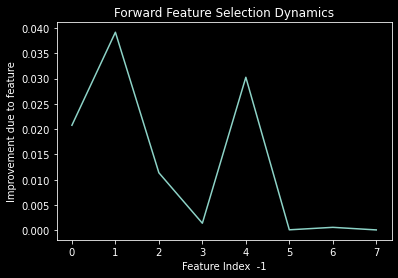

Selected Feature Indices
[18, 21, 1, 2, 24, 15, 44, 33, 42]
CPU times: user 1.71 s, sys: 635 ms, total: 2.34 s
Wall time: 8min 32s


In [38]:
%%time
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
selected = auto_forward_select(model, X, y, indices, scoring='accuracy', cv=3, n_selected=0, show_details=True)

---

## Modeling

- We see that with just 9 features we can beat the initial accuracy. However simple accuracy does not make a great model. We dont know what the ROC curves will look like. But if **model eplainability** was important (which it is for banks) we would go with this one for sure.
- I could also try **backward feature elimination** but that will also take too long and does not guarantee any definite improvement. 
- So I am going to manually try the following 4 sets and compare accuracies and ROC_AUC:
    - All features cv=5
    - First 2- features cv=5 (These features have preliminary feature importance > 1%)
    - Selected features from above cv=5
    - PCA 20 features cv=5

**All features**

In [59]:
%%time
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
s1 = cross_validate(model ,X, y, scoring=['accuracy', 'roc_auc'], cv=5, n_jobs=-1)
print('Mean Accuracy:', round(s1['test_accuracy'].mean(), 4), '|', 'STD:',round(s1['test_accuracy'].std(), 4))
print('Mean ROC_AUC :', round(s1['test_roc_auc'].mean(), 4), '|', 'STD:',round(s1['test_roc_auc'].std(), 4))

Mean Accuracy: 0.9038 | STD: 0.0016
Mean ROC_AUC : 0.9277 | STD: 0.0012
CPU times: user 70.5 ms, sys: 66.4 ms, total: 137 ms
Wall time: 1min 24s


**Top features**

In [61]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
s1 = cross_validate(model, X[X.columns[:20]], y, scoring=['accuracy', 'roc_auc'], cv=5, n_jobs=-1)
print('Mean Accuracy:', round(s1['test_accuracy'].mean(), 4), '|', 'STD:',round(s1['test_accuracy'].std(), 4))
print('Mean ROC_AUC :', round(s1['test_roc_auc'].mean(), 4), '|', 'STD:',round(s1['test_roc_auc'].std(), 4))

Mean Accuracy: 0.8918 | STD: 0.0019
Mean ROC_AUC : 0.9197 | STD: 0.0022


**AutoSelected Features**

In [62]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
s1 = cross_validate(model, X[X.columns[selected[0]]], y, scoring=['accuracy', 'roc_auc'], cv=5, n_jobs=-1)
print('Mean Accuracy:', round(s1['test_accuracy'].mean(), 4), '|', 'STD:',round(s1['test_accuracy'].std(), 4))
print('Mean ROC_AUC :', round(s1['test_roc_auc'].mean(), 4), '|', 'STD:',round(s1['test_roc_auc'].std(), 4))

Mean Accuracy: 0.9108 | STD: 0.0007
Mean ROC_AUC : 0.9309 | STD: 0.0023


**Dimensionality Reduction (PCA)**

In [64]:
from sklearn.decomposition import PCA
pca = PCA(20)
X_pca = pca.fit_transform(X)
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
s1 = cross_validate(model, X_pca, y, scoring=['accuracy', 'roc_auc'], cv=5, n_jobs=-1)
print('Mean Accuracy:', round(s1['test_accuracy'].mean(), 4), '|', 'STD:',round(s1['test_accuracy'].std(), 4))
print('Mean ROC_AUC :', round(s1['test_roc_auc'].mean(), 4), '|', 'STD:',round(s1['test_roc_auc'].std(), 4))

Mean Accuracy: 0.8685 | STD: 0.0006
Mean ROC_AUC : 0.8732 | STD: 0.0021


Notes:
- We see that the accuracy as well as the auc score is best for the model with the custom features that I auto-selected. It is fascinating that only 9 features can beat the performance of others when all were the using same model.
- I am excited by this because this means I will be very neatly and cleanly able to explain my model and its predictions to the stakeholders, clients, etc. Also, we will not need to collect and maintain so much extra data which could save the organization time and money. It also makes ETL and data engineering, ingestion pipelines much smaller and reliable.
- I will now take this set of features and try to boost it some more by tuning hyper parameters

---

## HyperParameter Tuning

- I will now conduct hyper parameter tuning on the selected set of features. I have used a tree based model. It has many hyperparameters.
- I am going to run a grid search, but with so many combinations it can take too long.
- After some research I found a particular template which is time efficient and suggests to tune individual parameters one by one in a certain order for maximum result.
- Since the task states that ROC_AUC will be used for evaluation, I will try to optimize for it.

In [73]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
Xs = X[X.columns[selected[0]]].iloc[:50000]  # Reducing sice because this takes time
ys = y.iloc[:50000]

**1. n_estimators**

In [74]:
parameters = {'n_estimators':[50,100,200,500,1000]}
grid_search = GridSearchCV(estimator=estimator,  param_grid=parameters,  scoring='roc_auc', cv=3,  n_jobs=-1)
grid_search = grid_search.fit(Xs, ys)
print('best',grid_search.best_params_)
print("Mean : {}".format(grid_search.best_score_))

best {'n_estimators': 100}
Mean : 0.9230980727757542


In [81]:
estimator.set_params(n_estimators = 100);

**2. learning_rate**

In [77]:
parameters = [{'learning_rate' : [0.01, 0.05, 0.1, 0.5, 1]}]              
grid_search = GridSearchCV(estimator=estimator,  param_grid=parameters,  scoring='roc_auc', cv=3,  n_jobs=-1)
grid_search = grid_search.fit(Xs, ys)
print('best',grid_search.best_params_)
print("Mean : {}".format(grid_search.best_score_))

best {'learning_rate': 0.5}
Mean : 0.9213921079228641


In [83]:
# Since this is worse than before I will let it be the default value = None
estimator.set_params(learning_rate=None);

**3. max_depth**

In [84]:
parameters = {'max_depth':[4,5,7,10]}
grid_search = GridSearchCV(estimator=estimator,  param_grid=parameters,  scoring='roc_auc', cv=3,  n_jobs=-1)
grid_search = grid_search.fit(Xs, ys)
print('best',grid_search.best_params_)
print("Mean : {}".format(grid_search.best_score_))

best {'max_depth': 7}
Mean : 0.922006978002182


In [ ]:
# Since this is worse than before I will let it be the default value = None
estimator.set_params(max_depth=None);

I could go on but its taking too much time. The order I would follow would be:
- n_estimators
- learning_rate
- max_depth
- min_child_weight
- gamma
- subsample
- cosample_by

---

### Final Training

In [2]:
train_data = pd.read_csv('ML_Artivatic_dataset/train_data_processed.csv')
X = train_data.drop(['member_id', 'type'], axis=1)
selected_columns = [18, 21, 1, 2, 24, 15, 44, 33, 42]
X = X[X.columns[selected_columns]].copy()
y = pd.read_csv('ML_Artivatic_dataset/train_indessa.csv').pop('loan_status')
del train_data

In [90]:
X.head()

,last_week_pay,tot_cur_bal,int_rate,sub_grade,col_60 months,recoveries,col_RENT,col_medical,col_OTHER
0,26.0,28699.0,19.19,23,0,0.0,0,0,0
1,9.0,9974.0,10.99,9,0,0.0,0,0,0
2,9.0,38295.0,7.26,4,0,0.0,0,0,0
3,135.0,55564.0,19.72,20,0,0.0,1,0,0
4,96.0,47159.0,10.64,7,0,0.0,1,0,0


In [7]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
model.fit(X, y);

## Evaluating the predictions

I have not really done a deep dive or a 'root cause analysis' to find the reasons why the model is not predicting some values correctly, due to lack of time. But if I could I would do the following:

- Plot the confusion matrix at varying thresholds
- Plot ROC curves
- Isolate test cases where the prediction is wrong.
- Understand any pattern where the model always seems to go wrong.
- Use expert domain knowledge to add human knowledge to the model, either by creating special features or by adding manual overrides to improve the model.
- For eg. during EDA I notices that 99.9% cases of joint accounts do not default. So I could manually override the prediction of the model in this case.

In [94]:
test_data = pd.read_csv('ML_Artivatic_dataset/test_data_processed.csv')
X = test_data.drop(['member_id', 'type'], axis=1)
selected_columns = [18, 21, 1, 2, 24, 15, 44, 33, 42]
X = X[X.columns[selected_columns]].copy()
y = model.predict(X)
# y = model.predict_proba(X)[:, 1]

/Users/guru/miniconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [96]:
pd.Series(y).value_counts(normalize=True)

0    0.806821
1    0.193179
dtype: float64

- Looks like we are predicting more non-defaulters about 4% if the test data has the same distribution as train data.
- Depending on the business requirement we can select a threshold that makes a desirable trade-off for the individual accuracies of the classes

### Submission

In [101]:
submission = pd.DataFrame()
submission['member_id'] = test_data['member_id'].copy()
submission['loan_status'] = model.predict_proba(X)[:, 1]
submission.head()

,member_id,loan_status
0,11937648,0.091754
1,38983318,0.034781
2,27999917,0.063124
3,61514932,0.043493
4,59622821,0.028543


> **NOTE: The submission containes the probability of defaulting**

In [103]:
submission.to_csv('ML_Artivatic_dataset/submission.csv', index=False)

---

## Explaining the predictions

I understand Artivatic is in the business of insurances and its clients/partners are financial institutions. Most large banks and large organizations in general who have been around for some time operate very traditionally. Although they are embracing AI, they do not just want to believe model predictions made by someone half their age as a lot is at stake here. They are also strictly monitored by government bodies and usually play safe.

Hence it is of utmost importance to be able to explain the models and predictions. In this section I will use a technique called ```shap values``` given by **Lloyd Shapley, Nobel Prize Winner in Economics**. This is mostly applied in the context of game theory but is also becoming popular in the field of explainable AI.

### Shap Values

- In my words, shap value of a certain feature represents its effect on the final prediction. If not features were present we would just predict the average value of the target variable (in this case about 0.76). Each feature brings this number either up or down by a certain magnitude. That is exactly the shap value of that feature

In [4]:
import shap
shap.initjs()

In [10]:
explainer = shap.TreeExplainer(model, X.iloc[:10000], model_output="probability") # Not using all the data, ideally all should be used
shap_values = explainer(X.iloc[:300])

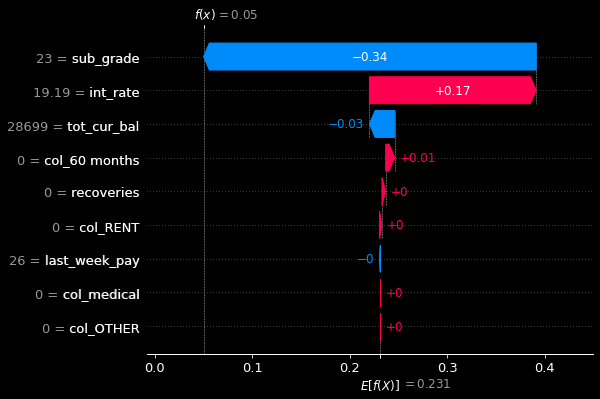

In [11]:
shap.plots.waterfall(shap_values[0])

This plot tells us about the first prediction, how much probability is added or subtracted by each feature. As can be seen that the center line is somewhere around 0.231, that means it is explaining the probability of default.
- So sub_grade for the first member_id is 23 and that subtracts 0.34 units of probability. 23 is among the lower grades and yet the model says that it indicates non-defaulter.
- However the interest rate is too high 19.2%. Which increases the probability to default. and so on.

Lets try one more

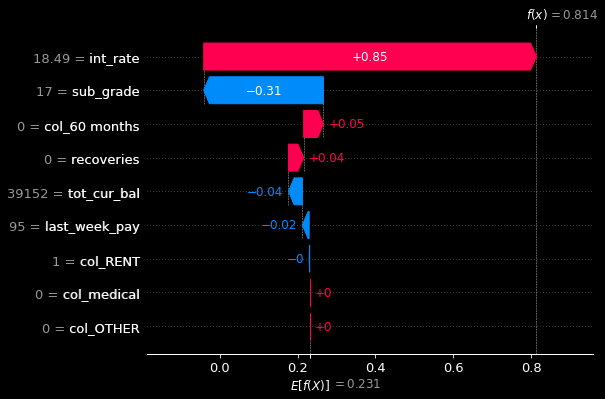

In [16]:
shap.plots.waterfall(shap_values[11])

This guy will default. His interest rate is too high, but grade is not that great. I am now realising that maybe A grades are bad and G grades are good. 

In [22]:
shap.force_plot(explainer.expected_value, shap_values[11].values, feature_names=X.columns)

Another way to visualize them is a force plot. Here you see that ```interest rate```, ```recoveries``` and ```term = 60 months``` are applying pressure to increase default probability and ```sub_grade```, ```tot_cur_bal``` are applying force to decrease it. Net result is still high probability for default

> There are many other cool visualsations to do with shap values but I am too tired to explain all of them here. So il leave it at this now.

---

## End Note:

- My goal in this task was to not chase a particular evaluation metric but rather to show my process and approach. I could not do many things since this is a time based task, but I have tried to write what I would try if I had the time in places.
- In the real world, I would first understand how the predictions will be consumed and then define a metric that would be best for that task. Train the model and balance the trade offs according to the exact business problem. And obviously deep dive a lot more into the data.

I hope you enjoyed this presentation. Looking forward to hearing from you.

-- Gyan Arora